## Analyze significance of paleoclimate anomaly composities using normal statistical tests and a resampling approach. This script will create composite average Temperature, Precipitation, and PDSI anomaly maps from the paleo-record from early (-7.67 days, >1 st. dev.) harvest years.

## Paleoclimate Datasets

* Seasonal temperature reconstruction (Lutberacher, 2004; Xoplaki, 2005):
    https://www.ncdc.noaa.gov/cdo/f?p=519:1:0::::P1_STUDY_ID:6288
* Seasonal precipitation reconstruction (Pauling, 2005):
    https://crudata.uea.ac.uk/cru/projects/soap/data/recon/#paul05
* Summer (JJA) PDSI reconstruction, Old World Drought Atlas (Cook, 2015):
    https://www.ncdc.noaa.gov/cdo/f?p=519:1:::::P1_STUDY_ID:19419
    
* Season of analysis: June-July-August (JJA)

## Tasks
* Load in the paleoclimate datasets and anomalize these datasets to zero mean over same interval as GHD-Core
* Pool together paleoclimate anomalies for early harvests
* 

## Setup
* Clear the workspace
* Load modules.
* Define function for plotting regional averaging rectangle on the maps.

In [316]:
reset -f

In [317]:
# Setup the Analysis
import calendar
import numpy as np
import netCDF4
import matplotlib
import copy
from matplotlib import pyplot as plt
import scipy
import seaborn as sns
import pandas as pd
import scipy.stats as stats
import datetime
from mpl_toolkits.basemap import Basemap, cm
from IPython.display import display

# Embeds plots inside the notebook
%matplotlib inline

# For plotting a rectangle on the maps
def plot_rectangle(bmap, lonmin,lonmax,latmin,latmax):
    xs = [lonmin,lonmax,lonmax,lonmin,lonmin]
    ys = [latmin,latmin,latmax,latmax,latmin]
    bmap.plot(xs, ys,latlon = True, color='k', linestyle='--', linewidth=3)

# Resampling function
def bootstrap_resample(X, n=None):
    """ Bootstrap resample an array_like
    Parameters
    ----------
    X : array_like
      data to resample
    n : int, optional
      length of resampled array, equal to len(X) if n==None
    Results
    -------
    returns X_resamples
    """
    if n == None:
        n = len(X)
        
    resample_i = np.floor(np.random.rand(n)*len(X)).astype(int)
    X_resample = X[resample_i]
    return X_resample

### Set the time intervals to coompare. 
* I am comparing early harvest composites from 1600-1980 against 1981-2007.

In [318]:
# User defined variables
# Years to sample from-I am going to split the analysis into an Early Period and a Later Period
yrs_before = np.arange(1600,1981); yrs_after  = np.arange(1981,2008);

# Rectangle Boundaries for regional averaging
lonmin=-2; lonmax=8; latmin=43; latmax=51

# baseline period for anomaly calculation. Should be same as base period in setp01_proc_ghd.py
base_period = np.arange(1600,1901)   

# User defined variables
# Set threshold GHD anomaly for compositing
harvest_thresh = -7.67;  # about 1 standard deviation for GHDmean or GHD core

# GHD Data to choose
ghd_name = 'GHDcore'


### Load in all the datasets: the GHD anomalies and the various paleoclimate reconstructions.

In [319]:
# Load and properly format wine data
infile= '../data/ghd_anom_doy_v02.csv'   # Name of the original data file

df=pd.read_csv(infile)

# Pull out year and mean as float64
yr = np.int64(df.Year)
ghd_mean = np.float64(df[ghd_name])

# Calculate standard deviation over base period
loc=np.where((yr>=np.min(base_period)) & (yr<=np.max(base_period)))[0]
std_ghd = np.nanstd(ghd_mean[loc])

#%%############################################################################
# Load OWDA Data
ncfile_owda = netCDF4.Dataset('/Users/bcook/Documents/GEODATA/OWDA/owda_hd_fix1_500.nc')

# Load OWDA Variables
lat_pdsi=ncfile_owda.variables['lat'][:];
lon_pdsi=ncfile_owda.variables['lon'][:];
yr_pdsi=ncfile_owda.variables['time'][:];
pdsi=ncfile_owda.variables['pdsi'][:];

# Swap PDSI axes so orientation is correct: time, lat, lon
pdsi=np.swapaxes(pdsi,0,2)

# close file
ncfile_owda.close

#%%############################################################################
# Load Luterbacher Temp Data
ncfile_luter = netCDF4.Dataset('/Users/bcook/Documents/GEODATA/LUTERTEMP/LuterbacherTemp.nc')

# Load Variables
lat_temp=ncfile_luter.variables['lat'][:];
lon_temp=ncfile_luter.variables['lon'][:];

# Luter is a seasonal temperature reconstruction, so create seasonal and year vectors
# 1=DJF, 2=MAM, 3=JJA, 4=SON
seas_luter = np.arange(1,5); seas_luter_all = np.transpose(np.tile(seas_luter,(1,503)))
yr_luter  = np.arange(1500,2003); 

# Now, pull out each season individually
tmp_locs = np.where(seas_luter_all==1); tmp_locs = tmp_locs[0]; tmp_DJF = ncfile_luter.variables['temp'][tmp_locs,0,:,:] 
tmp_locs = np.where(seas_luter_all==2); tmp_locs = tmp_locs[0]; tmp_MAM = ncfile_luter.variables['temp'][tmp_locs,0,:,:] 
tmp_locs = np.where(seas_luter_all==3); tmp_locs = tmp_locs[0]; tmp_JJA = ncfile_luter.variables['temp'][tmp_locs,0,:,:]
tmp_locs = np.where(seas_luter_all==4); tmp_locs = tmp_locs[0]; tmp_SON = ncfile_luter.variables['temp'][tmp_locs,0,:,:]

# close file
ncfile_luter.close

#%%############################################################################
# Load Pauling Precip Data
ncfile_pauling = netCDF4.Dataset('/Users/bcook/Documents/GEODATA/PAULINGPREC/PaulingPrecip.nc')

# Load Variables
lat_prec=ncfile_pauling.variables['lat'][:];
lon_prec=ncfile_pauling.variables['lon'][:];

# Luter is a seasonal temperature reconstruction, so create seasonal and year vectors
# 1=DJF, 2=MAM, 3=JJA, 4=SON
seas_paul = np.arange(1,5); seas_paul_all = np.transpose(np.tile(seas_luter,(1,501)))
yr_paul  = np.arange(1500,2001); 

# Now, pull out each season individually
pre_locs = np.where(seas_paul_all==1); pre_locs = pre_locs[0]; pre_DJF = ncfile_pauling.variables['precip'][pre_locs,0,:,:] 
pre_locs = np.where(seas_paul_all==2); pre_locs = pre_locs[0]; pre_MAM = ncfile_pauling.variables['precip'][pre_locs,0,:,:] 
pre_locs = np.where(seas_paul_all==3); pre_locs = pre_locs[0]; pre_JJA = ncfile_pauling.variables['precip'][pre_locs,0,:,:]
pre_locs = np.where(seas_paul_all==4); pre_locs = pre_locs[0]; pre_SON = ncfile_pauling.variables['precip'][pre_locs,0,:,:]

# close file
ncfile_pauling.close

<function Dataset.close>

### Convert the climate reconstructions to anomalies relative to the baseline period (1600-1900)

In [320]:
# Calculate Mean and recenter PDSI
# Find PDSI years for this period and calculate mean
i_yr_pdsi = np.where( (yr_pdsi>=np.min(base_period)) & (yr_pdsi<=np.max(base_period))); i_yr_pdsi=i_yr_pdsi[0];

base_mean_pdsi = np.mean(pdsi[i_yr_pdsi,:,:],axis=0)
pdsi_recenter=pdsi-base_mean_pdsi
#pdsi_recenter=copy.deepcopy(pdsi)

# Calculate Mean and Anomalize Temperature
i_yr_temp = np.where( (yr_luter>=np.min(base_period)) & (yr_luter<=np.max(base_period))); i_yr_temp=i_yr_temp[0];
tmp_DJF_mean = np.mean(tmp_DJF[i_yr_temp,:,:],axis=0)
tmp_MAM_mean = np.mean(tmp_MAM[i_yr_temp,:,:],axis=0)
tmp_JJA_mean = np.mean(tmp_JJA[i_yr_temp,:,:],axis=0)
tmp_SON_mean = np.mean(tmp_SON[i_yr_temp,:,:],axis=0)

tmp_DJF_anom = tmp_DJF-tmp_DJF_mean
tmp_MAM_anom = tmp_MAM-tmp_MAM_mean
tmp_JJA_anom = tmp_JJA-tmp_JJA_mean
tmp_SON_anom = tmp_SON-tmp_SON_mean

# Calculate Mean and Anomalize precipitation
i_yr_prec = np.where( (yr_paul>=np.min(base_period)) & (yr_paul<=np.max(base_period))); i_yr_prec=i_yr_prec[0];
pre_DJF_mean = np.mean(pre_DJF[i_yr_prec,:,:],axis=0)
pre_MAM_mean = np.mean(pre_MAM[i_yr_prec,:,:],axis=0)
pre_JJA_mean = np.mean(pre_JJA[i_yr_prec,:,:],axis=0)
pre_SON_mean = np.mean(pre_SON[i_yr_prec,:,:],axis=0)

# In mm
pre_DJF_anom = pre_DJF-pre_DJF_mean
pre_MAM_anom = pre_MAM-pre_MAM_mean
pre_JJA_anom = pre_JJA-pre_JJA_mean
pre_SON_anom = pre_SON-pre_SON_mean

# In percent
pre_JJA_anom_pct = (pre_JJA_anom/pre_JJA_mean)*100


### PDSI
* Create cosine-latitude weights for for spatial averaging 
* Regional average time series calculation (GHD-Core Region)

In [321]:
# Lat and lon indices for the specified region
i_lon_reg=np.where((lon_pdsi>=lonmin) & (lon_pdsi<=lonmax))[0]
i_lat_reg=np.where((lat_pdsi>=latmin) & (lat_pdsi<=latmax))[0]

# Latitude and Longitude Indices for this region
lon_reg = lon_pdsi[i_lon_reg]
lat_reg = lat_pdsi[i_lat_reg]

# Create Latitude Weights
lat_wts = scipy.cos(scipy.deg2rad(lat_reg));
lat_wts_grid,lon_junk = np.meshgrid(lat_wts,lon_reg)
lat_wts_grid=np.swapaxes(lat_wts_grid,1,0)

#------------------------------------------------------------------------------------------------------
# PDSI regional average

# Create dummy matrix
pdsi_reg_mean_wt=np.zeros(np.size(yr_pdsi))

# Loop Through Each Year
for i in enumerate(yr_pdsi):
    # Pull PDSI From the GHD-Core Region
    region_pdsi = pdsi_recenter[i[0],i_lat_reg,:][:,i_lon_reg]

    # Weighted Means
    pdsi_reg_mean_wt[i[0]] = np.ma.average(np.ma.masked_invalid(region_pdsi),weights=lat_wts_grid)

### Precipitation
* Create cosine-latitude weights for for spatial averaging 
* Regional average time series calculation (GHD-Core Region)

In [322]:
# Lat and lon indices for the specified region
i_lon_reg=np.where((lon_prec>=lonmin) & (lon_prec<=lonmax))[0]
i_lat_reg=np.where((lat_prec>=latmin) & (lat_prec<=latmax))[0]

# Latitude and Longitude Indices for this region
lon_reg = lon_prec[i_lon_reg]
lat_reg = lat_prec[i_lat_reg]

# Create Latitude Weights
lat_wts = scipy.cos(scipy.deg2rad(lat_reg));
lat_wts_grid,lon_junk = np.meshgrid(lat_wts,lon_reg)
lat_wts_grid=np.swapaxes(lat_wts_grid,1,0)

#------------------------------------------------------------------------------------------------------
# Precipitation regional average

# Create dummy matrix
preJJA_reg_mean_wt_pct=np.zeros(np.size(yr_paul))

# Loop Through Each Year
for i in enumerate(yr_paul):
    # Pull Precipitation From the GHD-Core Region
    region_prec = pre_JJA_anom_pct[i[0],i_lat_reg,:][:,i_lon_reg]

    # Unweighted and Weighted Means (mm)
    preJJA_reg_mean_wt_pct[i[0]] = np.ma.average(np.ma.masked_invalid(region_prec),weights=lat_wts_grid)

### Find all early harvest date years

In [323]:
# Find All Early Years
early_yrs = yr[np.where(ghd_mean<=harvest_thresh)]

# Find These Anomalies
early_anom = ghd_mean[np.where(ghd_mean<=harvest_thresh)]

# Get Rid of Any Data before 1600
remove_locs = np.where(early_yrs<1600)[0]
early_yrs   = np.delete(early_yrs,remove_locs)
early_anom  = np.delete(early_anom,remove_locs)

print("Early Years and Anomalies, GHD-Core (1600-2007)")
display(early_yrs)
display(early_anom)

Early Years and Anomalies, GHD-Core (1600-2007)


array([1602, 1603, 1604, 1605, 1607, 1610, 1611, 1615, 1616, 1619, 1623,
       1624, 1630, 1631, 1635, 1636, 1637, 1638, 1639, 1644, 1645, 1646,
       1647, 1651, 1653, 1659, 1660, 1661, 1665, 1666, 1668, 1669, 1670,
       1676, 1681, 1684, 1686, 1706, 1718, 1719, 1811, 1822, 1825, 1834,
       1846, 1862, 1865, 1868, 1870, 1874, 1893, 1901, 1904, 1905, 1906,
       1911, 1915, 1917, 1921, 1922, 1927, 1934, 1937, 1943, 1945, 1947,
       1950, 1952, 1959, 1960, 1961, 1976, 1982, 1989, 1990, 1992, 1993,
       1994, 1995, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007])

array([ -9.0292489 , -16.6292489 , -12.73438851,  -7.90884414,
        -8.4542489 , -11.10884414, -14.6792489 ,  -8.96884414,
       -14.76884414, -11.23438851,  -8.06884414, -13.68438851,
        -9.03438851, -12.18438851,  -8.43438851, -16.80938851,
       -20.15938851, -15.63438851,  -9.63438851,  -9.58438851,
       -15.38438851,  -9.85938851,  -7.75938851, -12.48438851,
        -9.80884414, -17.45938851, -16.01297464, -11.20938851,
        -7.88639764, -10.10884414,  -7.98438851,  -9.55938851,
        -7.85938851,  -8.33438851,  -9.48438851, -11.68438851,
       -11.20938851,  -9.22946483, -15.06946483,  -7.86946483,
       -10.12362762, -28.2314244 ,  -8.34571012, -13.27428155,
       -12.40170012,  -7.87428155, -18.01713869, -14.11713869,
       -12.17428155,  -8.65999583, -23.90285298,  -9.61713869,
       -10.40285298,  -8.25999583,  -8.01713869, -13.96839949,
       -10.05170012, -12.01777348, -11.76248941,  -7.94820369,
        -8.21963226, -14.66408083, -11.5355094 , -12.43

### Early Harvest Dates: 1600-1980

In [324]:
# Index locations
i_early = np.where((early_yrs>=np.min(yrs_before)) & (early_yrs<=np.max(yrs_before)))[0]

# Pull out yrs/anomalies based on this index
subset_yrs_before  = early_yrs[i_early]
subset_anom_before = early_anom[i_early]

print("Early Yrs: "+np.str(np.min(yrs_before))+'-'+np.str(np.max(yrs_before))+' (n='+ np.str(np.size(subset_yrs_before)) +')')
print("")
print(subset_yrs_before)
print("")
print("Early Dates: "+np.str(np.min(yrs_before))+'-'+np.str(np.max(yrs_before))+' (n='+ np.str(np.size(subset_anom_before)) +')')
print("")
print(subset_anom_before)
print("")
print("Mean Anomaly: "+np.str(np.mean(subset_anom_before))+" days early")
print("")

Early Yrs: 1600-1980 (n=72)

[1602 1603 1604 1605 1607 1610 1611 1615 1616 1619 1623 1624 1630 1631 1635
 1636 1637 1638 1639 1644 1645 1646 1647 1651 1653 1659 1660 1661 1665 1666
 1668 1669 1670 1676 1681 1684 1686 1706 1718 1719 1811 1822 1825 1834 1846
 1862 1865 1868 1870 1874 1893 1901 1904 1905 1906 1911 1915 1917 1921 1922
 1927 1934 1937 1943 1945 1947 1950 1952 1959 1960 1961 1976]

Early Dates: 1600-1980 (n=72)

[ -9.0292489  -16.6292489  -12.73438851  -7.90884414  -8.4542489
 -11.10884414 -14.6792489   -8.96884414 -14.76884414 -11.23438851
  -8.06884414 -13.68438851  -9.03438851 -12.18438851  -8.43438851
 -16.80938851 -20.15938851 -15.63438851  -9.63438851  -9.58438851
 -15.38438851  -9.85938851  -7.75938851 -12.48438851  -9.80884414
 -17.45938851 -16.01297464 -11.20938851  -7.88639764 -10.10884414
  -7.98438851  -9.55938851  -7.85938851  -8.33438851  -9.48438851
 -11.68438851 -11.20938851  -9.22946483 -15.06946483  -7.86946483
 -10.12362762 -28.2314244   -8.34571012 -13.27

### Early Harvest Dates: 1981-2007

In [325]:
# Year Lable for this interval

# Index locations
i_early = np.where((early_yrs>=np.min(yrs_after)) & (early_yrs<=np.max(yrs_after)))[0]

# Pull out yrs/anomalies based on this index
subset_yrs_after  = early_yrs[i_early]
subset_anom_after = early_anom[i_early]

print("Early Yrs: "+np.str(np.min(yrs_after))+'-'+np.str(np.max(yrs_after))+'\
    (n='+ np.str(np.size(subset_yrs_after)) +')')
print("")
print(subset_yrs_after)
print("")
print("Early Dates: "+np.str(np.min(yrs_after))+'-'+np.str(np.max(yrs_after))+'\
    (n='+ np.str(np.size(subset_anom_after)) +')')
print("")
print(subset_anom_after)
print("")
print("Mean Anomaly: "+np.str(np.mean(subset_anom_after))+" days early")
print("")

Early Yrs: 1981-2007    (n=18)

[1982 1989 1990 1992 1993 1994 1995 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007]

Early Dates: 1981-2007    (n=18)

[-10.03089949 -17.28089949 -13.31839949 -10.84339949 -12.64339949
 -15.36839949  -9.59339949 -12.51839949 -12.83089949 -12.30589949
 -14.54339949 -10.86839949 -10.09339949 -31.39339949  -8.49339949
 -16.25589949 -14.40534655 -20.90879529]

Mean Anomaly: -14.0942240977 days early



### PDSI and Precipitation anomalies for composite comparisons: 1981-2007 vs 1600-1980

In [326]:
# Setup dummy variables first
pdsi_early = np.zeros(np.size(early_yrs))
prec_early = np.zeros(np.size(early_yrs)-7)

# Loop Through Each Year in "early_yrs" and find the matching year in yr_pdsi
for i in enumerate(early_yrs):
    # Locate this year for PDSI
    loc_yr           = np.where(yr_pdsi==i[1])[0]
    pdsi_early[i[0]] = pdsi_reg_mean_wt[loc_yr]
    
    # Locate this year for Precipitation
    loc_yr           = np.where(yr_paul==i[1])[0]
    if loc_yr.size == 1:
        prec_early[i[0]] = preJJA_reg_mean_wt_pct[loc_yr]
    
display("----------------------------------------------------------------------------")
display("PDSI Anomalies")
display("----------------------------------------------------------------------------")
display(pdsi_early)
display('')
display("----------------------------------------------------------------------------")
display("Precipitation Anomalies")
display("----------------------------------------------------------------------------")
display(prec_early)

'----------------------------------------------------------------------------'

'PDSI Anomalies'

'----------------------------------------------------------------------------'

array([-1.71456288, -2.63627777,  0.39871293,  1.66678376,  2.19991057,
        0.15577673,  1.60275889, -1.66523737, -1.4348618 , -0.08021638,
       -2.28770339, -2.38648262, -0.59675533, -0.12570456, -1.79478855,
       -3.35883845,  0.09542955,  1.8740965 ,  1.92122985, -1.71939353,
       -1.21214528, -0.23338281, -0.22130693, -0.209721  , -3.5090866 ,
       -1.70540202,  0.99506323,  1.10613611, -1.93650238, -3.1892386 ,
       -0.49988638, -2.18338199, -2.64429886, -2.67115667, -4.30486273,
       -3.83748614, -0.11008701, -1.29142192, -2.75194533, -4.39100068,
       -2.86028041, -3.07598157, -0.02142846, -2.34305103, -0.92774132,
       -0.70350076, -4.14059275, -1.10345858, -3.43267997, -1.64444901,
       -4.19956128,  1.0813962 ,  0.30167382, -0.46514907, -1.90194537,
       -0.38971033,  1.31002021,  1.98035787, -5.11948453,  0.01719091,
        2.81169211, -3.0893924 ,  0.78026511, -1.45722119, -0.90514989,
       -2.47602345,  0.30565054, -0.77703911,  0.26298173,  2.06

''

'----------------------------------------------------------------------------'

'Precipitation Anomalies'

'----------------------------------------------------------------------------'

array([  8.75018232, -18.66310444, -12.09838482,   1.0996222 ,
        -9.70986657,   8.20686806,   7.20308776, -37.94489036,
       -47.32403561,  -2.45680082, -18.04909502,   9.33745675,
       -37.01302478, -30.41884367, -11.24393756,   4.31060144,
        -4.45570069,   2.27161403,  27.0861328 ,  -3.71630677,
       -15.57964518,  -1.99616772,  22.64709035,   3.11829788,
       -20.99984523,  20.80871861, -12.2364533 ,   5.05641391,
        23.33517252, -63.00952827,  28.72066726, -87.1353121 ,
         8.98549205, -42.05688265, -58.96682153, -43.98945849,
         1.1782421 , -70.2851281 , -45.65198353, -59.97379865,
         1.94167511,  -6.35164421, -23.19032123,  17.52323452,
        -8.23355486,   3.17972398,   7.4191068 , -12.46357172,
       -23.59143171, -10.54353389, -16.24592519, -13.06738777,
       -17.52746926,  12.54083566, -47.70760192, -24.11569192,
        -2.33859766,  22.91786265, -20.77635143,  15.19091802,
        43.14141993,  -3.39920687, -22.19623465, -10.86

### PDSI Comparison: 1981-2007 vs 1600-1980

PDSI Early Years Before:
[ 1602.  1603.  1604.  1605.  1607.  1610.  1611.  1615.  1616.  1619.
  1623.  1624.  1630.  1631.  1635.  1636.  1637.  1638.  1639.  1644.
  1645.  1646.  1647.  1651.  1653.  1659.  1660.  1661.  1665.  1666.
  1668.  1669.  1670.  1676.  1681.  1684.  1686.  1706.  1718.  1719.
  1811.  1822.  1825.  1834.  1846.  1862.  1865.  1868.  1870.  1874.
  1893.  1901.  1904.  1905.  1906.  1911.  1915.  1917.  1921.  1922.
  1927.  1934.  1937.  1943.  1945.  1947.  1950.  1952.  1959.  1960.
  1961.  1976.]

PDSI Values Before:
[-1.71456288 -2.63627777  0.39871293  1.66678376  2.19991057  0.15577673
  1.60275889 -1.66523737 -1.4348618  -0.08021638 -2.28770339 -2.38648262
 -0.59675533 -0.12570456 -1.79478855 -3.35883845  0.09542955  1.8740965
  1.92122985 -1.71939353 -1.21214528 -0.23338281 -0.22130693 -0.209721
 -3.5090866  -1.70540202  0.99506323  1.10613611 -1.93650238 -3.1892386
 -0.49988638 -2.18338199 -2.64429886 -2.67115667 -4.30486273 -3.83748614
 -0.110

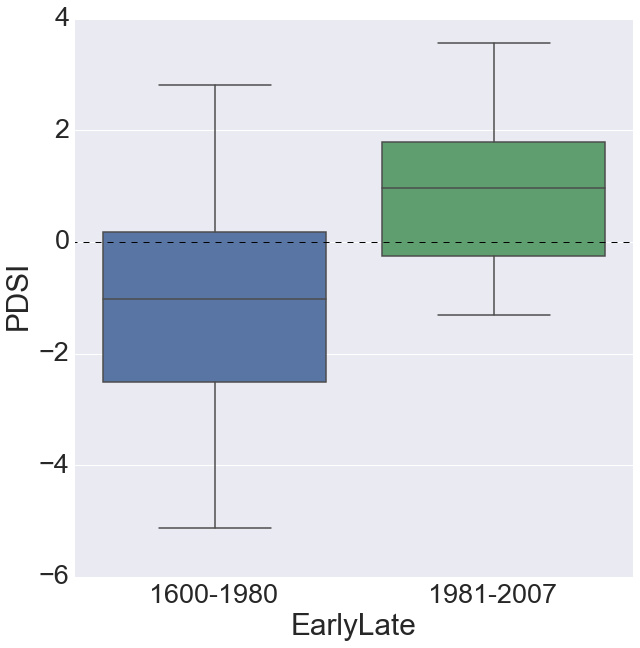

In [327]:
# Split PDSI Series
pdsi_locs=np.where(np.int64(np.in1d(yr_pdsi,subset_yrs_before))==1)[0];  pdsi_before = pdsi_reg_mean_wt[pdsi_locs]
print("PDSI Early Years Before:")
print(yr_pdsi[pdsi_locs])
print("")
print("PDSI Values Before:")
print(pdsi_before)
print("")
print("Mean PDSI: "+np.str(np.mean(pdsi_before)))
print("")
print("------------------------------------------------------------------------------------")
pdsi_locs=np.where(np.int64(np.in1d(yr_pdsi,subset_yrs_after))==1)[0];   pdsi_after  = pdsi_reg_mean_wt[pdsi_locs]
print("PDSI Early Years After:")
print(yr_pdsi[pdsi_locs])
print("")
print("PDSI Values After:")
print(pdsi_after)
print("")
print("Mean PDSI: "+np.str(np.mean(pdsi_after)))
print("")

#----------------------------------------------------------------------------------------------------------------
# Mean/Median Statistical Testing (Student's t-test, Wilcoxon Rank Sum)

# Labels
group_before = (np.str(yrs_before[0])+'-'+np.str(yrs_before[-1]));
group_after  = (np.str(yrs_after[0])+'-'+np.str(yrs_after[-1]));

label_1 = (np.tile(group_before,np.size(pdsi_before)))
label_2 = (np.tile(group_after,np.size(pdsi_after)))

# Initialize Matrix
mean_median_pdsi = np.zeros([3,3])

# Calculate the mean and median PDSI
mean_median_pdsi[0,0] = np.int64(np.size(pdsi_before))
mean_median_pdsi[0,1] = np.int64(np.size(pdsi_after))

mean_median_pdsi[1,0] = np.mean(pdsi_before)
mean_median_pdsi[1,1] = np.mean(pdsi_after)
mean_median_pdsi[1,2] = stats.ttest_ind(pdsi_before, pdsi_after)[1]

mean_median_pdsi[2,0] = np.median(pdsi_before)
mean_median_pdsi[2,1] = np.median(pdsi_after)
mean_median_pdsi[2,2] = stats.ranksums(pdsi_before, pdsi_after)[1]

# Create A DataFrame for Statistical Results
col_core_comp_txt=[label_1[0],label_2[0],"Diff, Pval"]
row_core_comp_txt=["n","Mean PDSI","Median PDSI"]
df_pdsi_stat_results  = pd.DataFrame(mean_median_pdsi, index=row_core_comp_txt, columns=col_core_comp_txt)

df_pdsi_stat_results

#----------------------------------------------------------------------------------------------------------------
# Create Dataframe (necessary for boxplot with seaborn)
col_txt = row_core_comp_txt=["PDSI","Year","EarlyLate"]

# Find all Early Years
df_pdsi_early      = pd.DataFrame(columns = col_txt)
df_pdsi_early.PDSI = pdsi_early
df_pdsi_early.Year = early_yrs

h=np.where(df_pdsi_early.Year<=1980)[0]
df_pdsi_early.loc[h,'EarlyLate'] = '1600-1980'

h=np.where(df_pdsi_early.Year>1980)[0]
df_pdsi_early.loc[h,'EarlyLate']  = '1981-2007'

# PDSI Boxplot
sns.plt.close(); sns.set(); 
sns.set_context("notebook", font_scale=2.7, rc={"lines.linewidth": 1.5})
fig = sns.plt.figure(figsize=(10,10))
sns.boxplot(x="EarlyLate", y="PDSI", data=df_pdsi_early)
sns.plt.plot([-10,20],[0,0],'--', color='k',linewidth=1)
#sns.plt.title('Mean PDSI, Early Harvests')  
#sns.plt.tight_layout
#sns.plt.savefig('../figures/step05/ghdcore.boxplot.pdsi.'+label_1[0]+'.'+label_2[0]+'.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator 


In [328]:
df_pdsi_stat_results

,1600-1980,1981-2007,"Diff, Pval"
n,72.000000,18.000000,0.000000
Mean PDSI,-1.069217,0.857061,0.000094
Median PDSI,-1.015600,0.962928,0.000241


### Resampling procedure for PDSI
* Because of potential sampling biases, I will run a resampling procedure to determine to what extent these difference could arise from chance due to the years including in the before and after PDSI composite. The procedure follows.
* I will run the resampling 10,000 times.
* For each iteration, the PDSI after pool (n=18) will remain the same. I will randomly sample (with replacement) from the pools of PDSI before, sampling 18 times (the same n as after). For each iteration, I will then repeat the t-test and ranksum tests.
* I then count the fraction of iterations where the t-test and ranksum test are still significant.
* Because I am a priori looking for a situation where PDSI is DRIER pre-1980, I am using a one-sided test.

Resampling Results:
Fraction t-test pass=0.9917
Fraction ranksum pass=0.9704


The results hold up well to the resampling. We can therefore conclude that sampling biases are unlikely to be biasing the results.



(-2.75, 1.5)

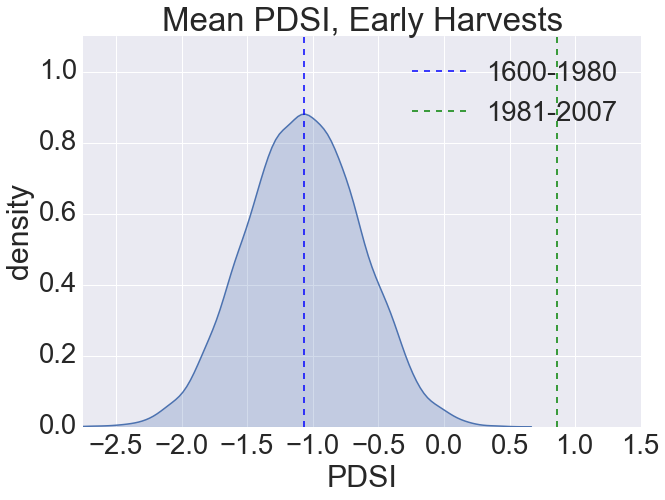

In [329]:
# Number of iterations
num_mc = 10000;

# I will draw randomly PDSI values from all early years and calculate average. The number I
# draw for each iteration will equal the # early years after 1950.
pdsi_resamp_mean_before    = np.zeros(num_mc)
pdsi_resamp_mean_after     = np.zeros(num_mc)
pval_mc_pdsi_ttest2        = np.zeros(num_mc)
pval_mc_pdsi_ranksum       = np.zeros(num_mc)
pval_mc_pdsibefore_onesamp = np.zeros(num_mc)
pval_mc_pdsiafter_onesamp  = np.zeros(num_mc)

# In each iteration, randomly resample (with replacement)
for i in np.arange(0,num_mc):
    
    #print(i)
    # First, Generate resampled PDSI for before and after periods
    pdsi_resamp_before = bootstrap_resample(pdsi_before,np.size(pdsi_after))
    pdsi_resamp_after  = copy.deepcopy(pdsi_after)
    #pdsi_resamp_after  = bootstrap_resample(pdsi_after,np.size(pdsi_after))

    # Now, calculate and store the resampled means
    pdsi_resamp_mean_before[i] = np.mean(pdsi_resamp_before)
    pdsi_resamp_mean_after[i] = np.mean(pdsi_resamp_after)

    # Ttest and Ranksum tests
    pval_mc_pdsi_ttest2[i] = stats.ttest_ind(pdsi_resamp_before,pdsi_resamp_after)[1]
    pval_mc_pdsi_ranksum[i] = stats.ranksums(pdsi_resamp_before,pdsi_resamp_after)[1]
    pval_mc_pdsibefore_onesamp[i] = stats.ttest_1samp(pdsi_resamp_before,0)[1]
    pval_mc_pdsiafter_onesamp[i]  = stats.ttest_1samp(pdsi_resamp_after,0)[1]

# Percent Simulations Where ttest and ranksum were significantly different
mc_ttest_sig   = np.size(np.where(pval_mc_pdsi_ttest2<=0.1))/np.size(pval_mc_pdsi_ttest2)
mc_ranksum_sig = np.size(np.where(pval_mc_pdsi_ranksum<=0.1))/np.size(pval_mc_pdsi_ranksum)
 
print("Resampling Results:")
print('Fraction t-test pass='+np.str(mc_ttest_sig))
print('Fraction ranksum pass='+np.str(mc_ranksum_sig))
print("")
print("")
print("The results hold up well to the resampling. We can therefore conclude that sampling biases are unlikely to be biasing the results.")
print("")
# Kernal Density Function from Resampling Results
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=2.75, rc={"lines.linewidth": 1.5})
#sns.set_context("notebook", font_scale=2, rc={'axes.labelsize': 64, 'ytick.minor.size': 32, 'axes.titlesize': 30})
bins=np.arange(-2.5,1,.125)  
sns.plt.figure(figsize=[10,7])     
sns.kdeplot(pdsi_resamp_mean_before,shade=True)
sns.kdeplot(pdsi_resamp_mean_after,shade=True,color='g')
sns.plt.plot([np.mean(pdsi_before),np.mean(pdsi_before)],[0,2],'--', color='b')
sns.plt.plot([np.mean(pdsi_after),np.mean(pdsi_after)],[0,2],'--', color='g')
sns.plt.xlabel('PDSI')
sns.plt.ylabel('density')
sns.plt.title('Mean PDSI, Early Harvests')  
sns.plt.legend(['1600-1980','1981-2007'])
sns.plt.tight_layout
sns.plt.ylim(0,1.1)
sns.plt.xlim(-2.75,1.5)
#sns.plt.savefig('../figures/step05/ghdcore.montecarlo.pdsi.'+label_1[0]+'.'+label_2[0]+'.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator 



### Precipitation Comparison: 1981-2007 vs 1600-1980

Prec Early Years Before:
[1602 1603 1604 1605 1607 1610 1611 1615 1616 1619 1623 1624 1630 1631 1635
 1636 1637 1638 1639 1644 1645 1646 1647 1651 1653 1659 1660 1661 1665 1666
 1668 1669 1670 1676 1681 1684 1686 1706 1718 1719 1811 1822 1825 1834 1846
 1862 1865 1868 1870 1874 1893 1901 1904 1905 1906 1911 1915 1917 1921 1922
 1927 1934 1937 1943 1945 1947 1950 1952 1959 1960 1961 1976]

Prec Values Before:
[  8.75018232 -18.66310444 -12.09838482   1.0996222   -9.70986657
   8.20686806   7.20308776 -37.94489036 -47.32403561  -2.45680082
 -18.04909502   9.33745675 -37.01302478 -30.41884367 -11.24393756
   4.31060144  -4.45570069   2.27161403  27.0861328   -3.71630677
 -15.57964518  -1.99616772  22.64709035   3.11829788 -20.99984523
  20.80871861 -12.2364533    5.05641391  23.33517252 -63.00952827
  28.72066726 -87.1353121    8.98549205 -42.05688265 -58.96682153
 -43.98945849   1.1782421  -70.2851281  -45.65198353 -59.97379865
   1.94167511  -6.35164421 -23.19032123  17.52323452  -8.233

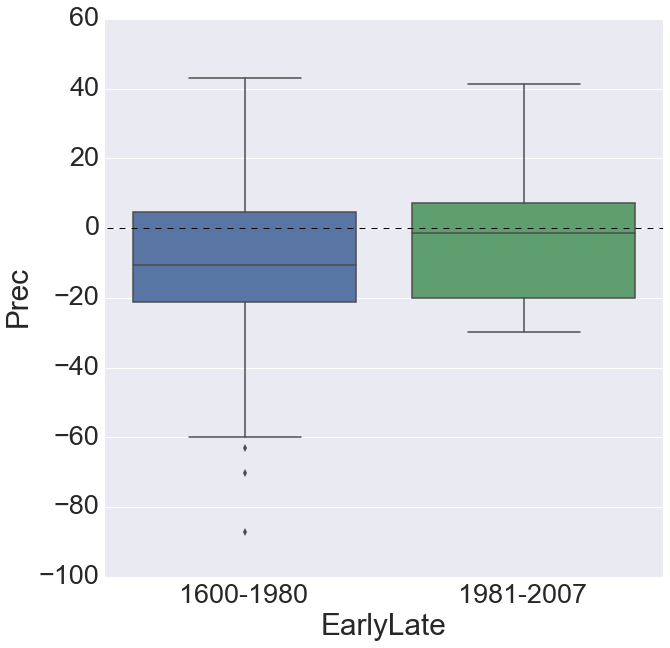

In [330]:
# Split Prec Series

prec_locs   = np.where(np.int64(np.in1d(yr_paul,subset_yrs_before))==1)[0];  
prec_before = preJJA_reg_mean_wt_pct[prec_locs]

print("Prec Early Years Before:")
print(yr_paul[prec_locs])
print("")
print("Prec Values Before:")
print(prec_before)
print("")
print("Mean Prec: "+np.str(np.mean(prec_before)))
print("")
print("------------------------------------------------------------------------------------")

prec_locs   = np.where(np.int64(np.in1d(yr_paul,subset_yrs_after))==1)[0];   
prec_after  = preJJA_reg_mean_wt_pct[prec_locs]

print("Prec Early Years After:")
print(yr_paul[prec_locs])
print("")
print("Prec Values After:")
print(prec_after)
print("")
print("Mean Prec: "+np.str(np.mean(prec_after)))
print("")

#----------------------------------------------------------------------------------------------------------------
# Mean/Median Statistical Testing (Student's t-test, Wilcoxon Rank Sum)

# Labels
group_before = (np.str(yrs_before[0])+'-'+np.str(yrs_before[-1]));
group_after  = (np.str(yrs_after[0])+'-'+np.str(yrs_after[-1]));

label_1 = (np.tile(group_before,np.size(prec_before)))
label_2 = (np.tile(group_after,np.size(prec_after)))

# Initialize Matrix
mean_median_prec = np.zeros([3,3])

# Calculate the mean and median PDSI
mean_median_prec[0,0] = np.int64(np.size(prec_before))
mean_median_prec[0,1] = np.int64(np.size(prec_after))

mean_median_prec[1,0] = np.mean(prec_before)
mean_median_prec[1,1] = np.mean(prec_after)
mean_median_prec[1,2] = stats.ttest_ind(prec_before, prec_after)[1]

mean_median_prec[2,0] = np.median(prec_before)
mean_median_prec[2,1] = np.median(prec_after)
mean_median_prec[2,2] = stats.ranksums(prec_before, prec_after)[1]

# Create A DataFrame for Statistical Results
col_core_comp_txt=[label_1[0],label_2[0],"Diff, Pval"]
row_core_comp_txt=["n","Mean Prec","Median Prec"]
df_prec_stat_results  = pd.DataFrame(mean_median_prec, index=row_core_comp_txt, columns=col_core_comp_txt)

df_prec_stat_results

#----------------------------------------------------------------------------------------------------------------
# Create Dataframe (necessary for boxplot with seaborn)
col_txt = row_core_comp_txt=["Prec","Year","EarlyLate"]

# Find all Early Years
df_prec_early      = pd.DataFrame(columns = col_txt)
df_prec_early.Prec = prec_early
df_prec_early.Year = early_yrs[np.where(early_yrs<=2000)]

h=np.where(df_prec_early.Year<=1980)[0]
df_prec_early.loc[h,'EarlyLate'] = '1600-1980'

h=np.where(df_prec_early.Year>1980)[0]
df_prec_early.loc[h,'EarlyLate']  = '1981-2007'

# Prec Boxplot
sns.plt.close(); sns.set(); 
sns.set_context("notebook", font_scale=2.7, rc={"lines.linewidth": 1.5})
fig = sns.plt.figure(figsize=(10,10))
sns.boxplot(x="EarlyLate", y="Prec", data=df_prec_early)
sns.plt.plot([-10,20],[0,0],'--', color='k',linewidth=1)
#sns.plt.title('Mean PDSI, Early Harvests')  
#sns.plt.tight_layout
#sns.plt.savefig('../figures/step05/ghdcore.boxplot.pdsi.'+label_1[0]+'.'+label_2[0]+'.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator 

### Result from two sample Student's t-test and Ranksum Test

In [331]:
df_prec_stat_results

,1600-1980,1981-2007,"Diff, Pval"
n,72.000000,11.000000,0.000000
Mean Prec,-11.002077,-1.285384,0.232533
Median Prec,-10.703221,-1.474914,0.484940


### Student's t versus 0 (i.e., are precipitation composites significantly dry)

In [332]:
#%%############################################################################
# Mean Statistical Testing versus Zero
#mean_median_prec[1,2] = stats.ttest_ind(prec_before, prec_after)[1]
print("")
print("Prec Before vs 0 (1 sample)")
t,p = stats.ttest_1samp(prec_before,0)
print("t-stat = "+np.str(t)+", pval = "+np.str(p))
print("")
print("Prec After vs 0 (1 sample)")
t,p = stats.ttest_1samp(prec_after,0)
print("t-stat = "+np.str(t)+", pval = "+np.str(p))


Prec Before vs 0 (1 sample)
t-stat = -3.70656243898, pval = 0.000412995635771

Prec After vs 0 (1 sample)
t-stat = -0.18353218759, pval = 0.858048435988


### Resampling procedure for precipitation

Resampling Results (One Sided pre-1980 vs 0, pval=0.05) :
Fraction t-test pass=0.3782

Resampling Results (One Sided pre-1980 vs post-1980, pval=0.10) :
Fraction t-test pass=0.2942



(-40, 30)

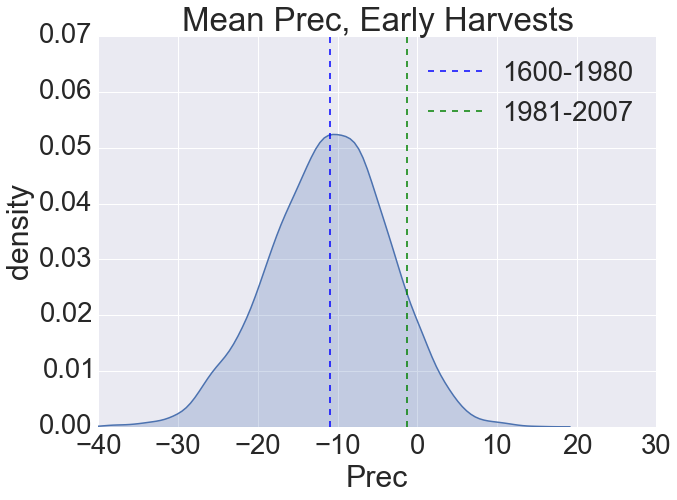

In [333]:
# Monte-Carlo

# Number of iterations
num_mc = 10000;

# I will draw randomly PDSI values from all early years and calculate average. The number I
# draw for each iteration will equal the # early years after 1950.
prec_resamp_mean_before    = np.zeros(num_mc)
prec_resamp_mean_after     = np.zeros(num_mc)
pval_mc_precbefore_onesamp = np.zeros(num_mc)
pval_mc_prec_ttest2        = np.zeros(num_mc)

# In each iteration, randomly resample (with replacement)
for i in np.arange(0,num_mc):
    
    #print(i)
    # First, Generate resampled Prec for before and after periods
    prec_resamp_before = bootstrap_resample(prec_before,np.size(prec_after))
    prec_resamp_after  = copy.deepcopy(prec_after)

    # Now, calculate and store the resampled means
    prec_resamp_mean_before[i] = np.mean(prec_resamp_before)
    prec_resamp_mean_after[i]  = np.mean(prec_resamp_after)

    # Ttest and tests
    pval_mc_prec_ttest2[i] = stats.ttest_ind(prec_resamp_before,prec_resamp_after)[1]
    pval_mc_precbefore_onesamp[i] = stats.ttest_1samp(prec_resamp_before,0)[1]

# Percent Simulations Where ttest and ranksum were significantly different
mc_ttest_sig           = np.size(np.where(pval_mc_precbefore_onesamp<=0.1))/np.size(pval_mc_precbefore_onesamp)
mc_ttest_sig_twosamp   = np.size(np.where(pval_mc_prec_ttest2<=0.2))/np.size(pval_mc_prec_ttest2)
 
print("Resampling Results (One Sided pre-1980 vs 0, pval=0.05) :")
print('Fraction t-test pass='+np.str(mc_ttest_sig))
print("")
print("Resampling Results (One Sided pre-1980 vs post-1980, pval=0.10) :")
print('Fraction t-test pass='+np.str(mc_ttest_sig_twosamp))
print("")

# Kernal Density Function from Resampling Results
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=2.75, rc={"lines.linewidth": 1.5})
#sns.set_context("notebook", font_scale=2, rc={'axes.labelsize': 64, 'ytick.minor.size': 32, 'axes.titlesize': 30})
bins=np.arange(-2.5,1,.125)  
sns.plt.figure(figsize=[10,7])     
sns.kdeplot(prec_resamp_mean_before,shade=True)
sns.kdeplot(prec_resamp_mean_after,shade=True,color='g')
#sns.plt.hist(pdsi_synth, bins, normed=True, alpha=0.7);
sns.plt.plot([np.mean(prec_before),np.mean(prec_before)],[0,2],'--', color='b')
sns.plt.plot([np.mean(prec_after),np.mean(prec_after)],[0,2],'--', color='g')
sns.plt.xlabel('Prec')
sns.plt.ylabel('density')
sns.plt.title('Mean Prec, Early Harvests')  
sns.plt.legend(['1600-1980','1981-2007'])
sns.plt.tight_layout
sns.plt.ylim(0,.07)
sns.plt.xlim(-40,30)
#sns.plt.savefig('../figures/step05/ghdcore.montecarlo.prec.'+label_1[0]+'.'+label_2[0]+'.svg', format='svg', dpi=1200) # vector graphics for adobe illustrator 

In [334]:
print("DONE!")
print("Last run: "+str(datetime.datetime.now()))

DONE!
Last run: 2016-01-05 08:27:54.525311
